In [12]:
# Section 1: Imports and Configuration
import os
import numpy as np
from pathlib import Path
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


import tensorflow as tf
%pip install --upgrade tensorflow keras

from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

Note: you may need to restart the kernel to use updated packages.


Found 2987 image files. First 5:
['01562828258.8049057.5.tiff', '10001562828258.6803238.8.tiff', '10091562828257.9266012.8.tiff', '10101562828257.8652837.1.tiff', '10131562828258.6860137.7.tiff']


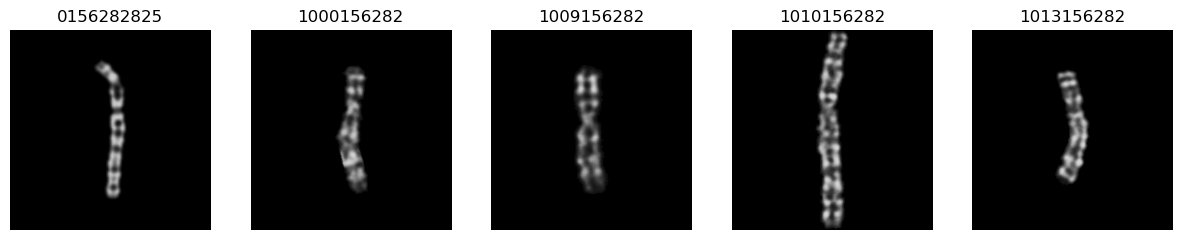

In [13]:
import os

root = r'C:/Users/erand/Desktop/task/task1/data'  # update to your actual dataset path
if not os.path.exists(root):
    print(f"Directory not found: {root}")
    files = []
else:
    files = [f for f in os.listdir(root) if f.lower().endswith(('tiff','tif','jpg','jpeg','png'))]

print("Found", len(files), "image files. First 5:")
print(files[:5])

# Show first 5 images
plt.figure(figsize=(15, 3))
for i, fname in enumerate(files[:5]):
    img = Image.open(os.path.join(root, fname)).convert('RGB')
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(fname[:10])  # shortened title
plt.show()

In [14]:
NUM_CLASSES = 24
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 1e-4
DATA_PATH = Path(r'C:\Users\erand\Desktop\task\task1\data')

def load_data():
    X, Y = [], []
    valid_ext = ('.jpg', '.jpeg', '.png', '.tiff', '.tif')

    for f in os.listdir(DATA_PATH):
        if f.lower().endswith(valid_ext):
            try:
                img_path = os.path.join(DATA_PATH, f)
                img = Image.open(img_path).convert('RGB').resize((IMAGE_SIZE, IMAGE_SIZE))
                X.append(np.array(img, dtype=np.float32) / 255.0)

                # Label is last token before extension
                label_str = f.split('.')[-2]  # e.g. "11"
                label = int(label_str) - 1    # convert to 0-indexed
                if 0 <= label < NUM_CLASSES:
                    Y.append(label)
                else:
                    X.pop()

            except Exception as e:
                print(f"Error loading {f}: {e}")
                if X and len(X) > len(Y):
                    X.pop()

    X, Y = np.array(X), np.array(Y)
    print(f"Loaded {len(X)} images. Label distribution: {Counter(Y)}")
    return X, Y

In [15]:
# Section 3: Model Architecture
def create_model():
    base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    for layer in base_model.layers[:-20]:
        layer.trainable = False


    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=outputs)

In [18]:
# Section 5: Train/Validation Split and Training
X, Y = load_data()
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

print("Training set:", X_train.shape, "Validation set:", X_val.shape)

model = create_model()
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Convert labels to one-hot encoding
y_train_cat = to_categorical(y_train, NUM_CLASSES)
y_val_cat = to_categorical(y_val, NUM_CLASSES)

# Data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

def get_callbacks(fold=1):
    return [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
        ModelCheckpoint(f'best_model_fold{fold}.h5', monitor='val_loss', save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    ]

history = model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val_cat),
    epochs=EPOCHS,
    callbacks=get_callbacks(fold=1),  # dummy fold value

    verbose=1
)


# Final evaluation
val_loss, val_acc = model.evaluate(X_val, y_val_cat, verbose=0)
print(f"Final validation accuracy: {val_acc:.4f}")


# Save final model
model.save('chromosome_classifier_final.h5')

Loaded 2856 images. Label distribution: Counter({4: 130, 7: 130, 0: 130, 15: 130, 3: 130, 19: 130, 16: 130, 5: 130, 18: 130, 20: 130, 13: 130, 1: 130, 12: 130, 2: 130, 8: 130, 9: 130, 11: 130, 6: 129, 17: 129, 14: 129, 10: 129, 21: 98, 22: 32})
Training set: (2284, 224, 224, 3) Validation set: (572, 224, 224, 3)


c:\Users\erand\.conda\envs\gpu_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
56/72 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.1172 - loss: 4.3501

KeyboardInterrupt: 

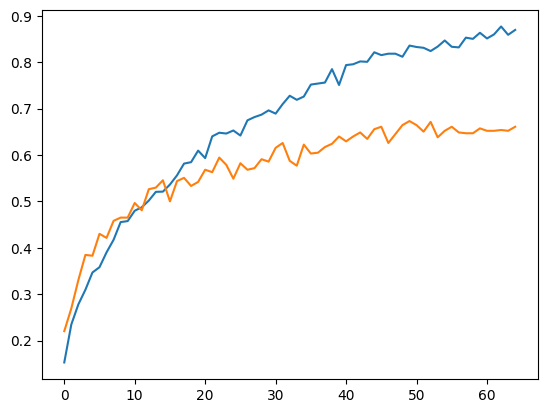

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [ ]:
# Section 7: Analysis
def analyze_original(model, image_path='original.jpg'):
    if not Path(image_path).exists():
        print(f"Original image {image_path} not found")
        return
    chromosomes = segment_chromosomes(image_path)
    if len(chromosomes) == 0:
        print("No chromosomes detected")
        return


preds = model.predict(chromosomes)
classes = np.argmax(preds, axis=1)
confs = np.max(preds, axis=1)
print(f"\n=== CHROMOSOME ANALYSIS ===")
print(f"Total chromosomes detected: {len(chromosomes)}")
for cid, cnt in Counter(classes).items():
    chr_name = f"Chr {cid+1}" if cid <= 21 else ("Chr X" if cid==22 else "Chr Y")
    print(f"{chr_name}: {cnt}")


# Visualization
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
for i, ax in enumerate(axes.flatten()):
    if i < len(chromosomes):
        ax.imshow(chromosomes[i])
        chr_name = f"Chr {classes[i]+1}" if classes[i]<=21 else ("Chr X" if classes[i]==22 else "Chr Y")
        ax.set_title(f"{chr_name}\n{confs[i]:.3f}")
        ax.axis('off')
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()


# Run Analysis
analyze_original(best_model)

NameError: name 'model' is not defined